<a href="https://colab.research.google.com/github/juanfrh7/uc-problem-annealing/blob/main/Discrete_Power_Systems_Portfolio_Optimization_using_Quantum_Annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install dwave-system
import dwave
from dwave.system import DWaveSampler, EmbeddingComposite
import dimod

from collections import defaultdict
from copy import deepcopy
from dwave.system import LeapHybridSampler
from dimod import BinaryQuadraticModel

try:
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

import numpy as np

import os
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Find composite index into 1D list for (nurse_index, day_index)
def get_index(generator_index, day_index):
    return generator_index * n_hours + day_index


# Inverse of get_index - given a composite index in a 1D list, return the
# nurse_index and day_index
def get_generator_and_day(index):
    nurse_index, day_index = divmod(index, n_hours)
    return nurse_index, day_index

def dict_to_mat(dic):
  # Determine the size of the matrix
  size = max(max(key) for key in dic.keys()) + 1

  # Create an empty matrix
  matrix = np.zeros((size, size))

  # Fill the matrix with the dictionary values
  for key, value in dic.items():
      matrix[key[0]][key[1]] = value

  # Print the resulting matrix
  return matrix

# Problem definition

There are many different UC problems, as the electrical system is structured and governed differently across the world. Common elements are:

- A time horizon along which the decisions have to be made, sampled at a finite number of time instants. This is usually one or two days, up to a week, where instants are usually hours or half-hours; less frequently, 15 or 5 minutes. Hence, time instants are typically between 24 and around 2000.
- A set of generating units with the corresponding energy production cost and/or emission curves, and (complex) technical constraints.
- A representation of the significant part of the grid network.
- A (forecasted) load profile to be satisfied, i.e., the net amount of energy to be delivered to each node of the grid network at each time instant.
- Possibly, a set of reliability constraints ensuring that demand will be satisfied even if some unforeseen events occur.
- Possibly, financial and/or regulatory conditions (energy revenues, market operation constraints, financial instruments, ...).

In [ ]:
n_generators = 10
n_hours = 24

# cost of power plants at different hours (?)
C = np.random.randint(1, 11, size=(n_hours, n_generators))

lagrange_hard_shift = 1.3 
generators_required = 2     # number of genereators required every hour - set to a constant for now
efficiency = 1        # efficiency of each generator - set to a constant for now

size = n_hours * n_generators

In [ ]:
# first we assign to the diagonal terms the cost of operating 
# each generator at each hour
K = defaultdict(int)
for generator in range(n_generators):
    for hour in range(n_hours - 1):
        generator_hour_1 = get_index(generator, hour)
        generator_hour_2 = get_index(generator, hour+1)
        K[generator_hour_1, generator_hour_2] = C[hour][generator]

# Q matrix assign the cost term, the J matrix
Q = deepcopy(K)

In [ ]:
# Set the print options to display the whole matrix
np.set_printoptions(threshold=np.inf)
A = dict_to_mat(Q)
#print(A)

**Hard shift constraint**: at least one generator working every hour. The sum of the enrgy is over each hour. This constraint tries to make (efficiency * sum(q_i)) equal to energy, which is set to a constant in this implementation, so that one generator is working each hour.

 Overall hard shift constraint:

 lagrange_hard_shift * sum_d ((sum_n(effort * q_i(n,d)) - workforce) ** 2)


with constant effort and constant workforce:
 = lagrange_hard_shift * sum_d ( effort * sum_n q_i(n,d) - workforce ) ** 2
 = lagrange_hard_shift * sum_d [ effort ** 2 * (sum_n q_i(n,d) * * 2) - 2 effort * workforce * sum_n q_i(n,d) + workforce ** 2 ]


 The constant term is moved to the offset, below, right before we solve the QUBO. Expanding and merging the terms ( m is another sum over n ):

 lagrange_hard_shift * (effort ** 2 - 2 effort * workforce) * sum_d sum_n q_i(n,d) + lagrange_hard_shift * effort ** 2 * sum_d sum_m sum_n q_i(n,d) q_j(m, d) 

This constraint limits the minimum number of generators working every day and we should aim at minimum energy so that the algorithm finds the optimal number of generators

In [ ]:
# include constraints as penalty terms
# Diagonal terms in hard shift constraint, without the workforce**2 term
for generator in range(n_generators):
    for hour in range(n_hours):
        ind = get_index(generator, hour)
        Q[ind, ind] += lagrange_hard_shift * (efficiency ** 2 - (2 * generators_required * efficiency))

# Off-diagonal terms in hard shift constraint
# Include only the same day, across nurses
for hour in range(n_hours):
    for generator1 in range(n_generators):
        for generator2 in range(generator1 + 1, n_generators):

            ind1 = get_index(generator1, hour)
            ind2 = get_index(generator2, hour)
            Q[ind1, ind2] += 2 * lagrange_hard_shift * efficiency ** 2

In [ ]:
# Solve the problem, and use the offset to scale the energy
e_offset = (lagrange_hard_shift * n_hours * generators_required ** 2)
bqm = BinaryQuadraticModel.from_qubo(Q, offset=e_offset)

print("\nSending problem to hybrid sampler...")
# Create a D-Wave sampler
sampler = EmbeddingComposite(DWaveSampler(solver='Advantage_system4.1'))
results = sampler.sample(bqm, label='Example - Power Plant Scheduling')

# Get the results
smpl = results.first.sample

# Graphics
print("\nBuilding schedule and checking constraints...\n")
sched = [get_generator_and_day(j) for j in range(size) if smpl[j] == 1]


Sending problem to hybrid sampler...

Building schedule and checking constraints...



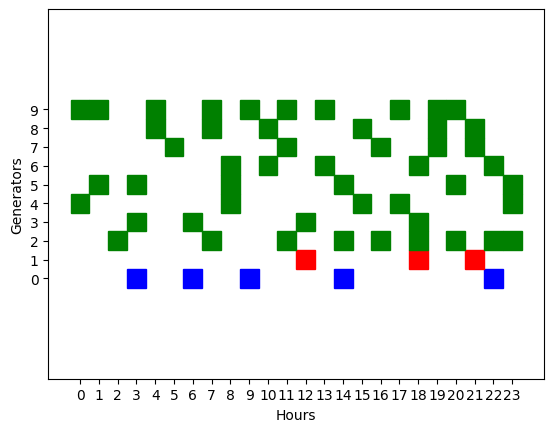

In [ ]:
# Save image of schedule
x,y = zip(*sched)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y, x)
width = 1
height = 1
for a_y, a_x in sched:
    if a_y == 0:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='blue', fill=True))
    elif a_y == 1:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='red', fill=True))
    else:
        ax.add_patch(Rectangle(
            xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
            linewidth=1, color='green', fill=True))
ax.axis('equal')
ax.set_xticks(range(n_hours))
ax.set_yticks(range(n_generators))
ax.set_xlabel("Hours")
ax.set_ylabel("Generators")
plt.savefig("schedule.png")


**Constraints**

In [ ]:
def power_generation_constraint(x, E, P, D):
    """The total power generated by all power plants should meet or exceed the demand."""
    #total_generation = np.dot(P, np.dot(E, x))
    total_generation = sum(E[i] * x[i] * P[i] for i in range(len(x)))
    return total_generation >= D

def reliability_constraint(x, p):
    """The reliability threshold of the power system should be maintained."""
    # Check the reliability of each power plant
    total_prob = np.dot(P, x)
    return total_prob >= p

def min_max_generation_constraint(x, min_generation, max_generation):
    """Each power plant should operate within its minimum 
    and maximum generation limits."""
    # Check the generation limits for each power plant
    for i in range(len(x)):
        if x[i] < min_generation[i] or x[i] > max_generation[i]:
            return False
    return True

def ramp_rate_constraint(x, previous_x, max_ramp_rate):
    """The rate at which the power generation can change 
    should be limited to avoid abrupt changes."""
    # Check the ramp rate for each power plant
    for i in range(len(x)):
        if abs(x[i] - previous_x[i]) > max_ramp_rate[i]:
            return False
    return True

# Classical algorithm (not working yet)

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define the QUBO objective function
def qubo_objective(x, Q):
    return 0.5 * np.dot(x, np.dot(Q, x))

# Define the constraint function
def constraint(x):
    return np.sum(x) - D

# Define the bounds for the variables
bounds = [(0, 1) for _ in range(n)]

x0 = [0] * n   

# Solve the QUBO problem using classical optimization
result = minimize(qubo_objective, x0=x0, args=(q_matrix,), constraints={'type': 'ineq', 'fun': power_generation_constraint(E, D)}, bounds=bounds)

# Print the solution
print("Optimization successful.")
print("Solution:", np.round(result.x))


TypeError: ignored

# Quantum annealer

In [ ]:
from dimod.constrained.constrained import ConstrainedQuadraticModel
# Define the QUBO problem
bqm = dimod.BinaryQuadraticModel.from_qubo(q)
cqm = ConstrainedQuadraticModel.from_quadratic_model(bqm)
cqm

In [ ]:


# Update the offset of the QUBO problem
#bqm.offset += sum(c.values())

# Set up the D-Wave sampler and sampler parameters
sampler = EmbeddingComposite(DWaveSampler(token=os.environ['DWAVE_API_TOKEN']))
num_reads = 1000
chain_strength = 9

# Solve the QUBO problem on the D-Wave system
#response = sampler.sample(bqm, num_reads=num_reads, chain_strength=chain_strength, answer_mode="raw")
response = sampler.sample(cqm, num_reads=100)

AttributeError: ignored

In [ ]:
response.record
response.first

Sample(sample={1: 0, 2: 1, 3: 1, 4: 0, 5: 1}, energy=-5.0, num_occurrences=21, chain_break_fraction=0.0)

In [ ]:
# Print the solutions and their energies
#for sample, energy in response.data(['sample', 'energy']):
    #print(sample, energy)

# Iterate through the solutions from the D-Wave sampler
for sample, energy in response.data(['sample', 'energy']):
    # Check if the solution satisfies the reliability constraint
    total_power = sum(sample[i] * E[i] for i in range(n))
    if total_power >= D:
        # Calculate the cost
        total_cost = sum(sample[i] * C[i] for i in range(n))
        # Check if the cost is lower and update the best solution if necessary
        if total_cost < dwave_best_cost:
            dwave_best_solution = sample
            dwave_best_cost = total_cost


print("D-Wave Best Solution:", dwave_best_solution)
print("D-Wave Cost:", dwave_best_cost)

In [ ]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import itertools

# Define the SUC problem parameters
n = 3  # number of power plants
D = 5  # demand
p = 0.9  # reliability threshold
E = [1, 2, 3]  # efficiency of power plants
C = [3, 4, 5]  # cost of power plants

# Define the QUBO problem parameters
q = {(i, j): 0 for i in range(n) for j in range(n)}
c = {i: 0 for i in range(n)}

# Define the QUBO objective function
for i in range(n):
    q[(i, i)] += C[i]
    for j in range(i + 1, n):
        q[(i, j)] += E[i] * E[j]
    c[i] += C[i]

# Define the power plant combinations
combinations = list(itertools.product([0, 1], repeat=n))

# Initialize the best solution and its cost from the classical algorithm
classical_best_solution = None
classical_best_cost = float('inf')

# Iterate through all possible solutions using the classical algorithm
for combination in combinations:
    # Calculate the total power and cost
    total_power = sum(combination[i] * E[i] for i in range(n))
    total_cost = sum(combination[i] * C[i] for i in range(n))

    # Check if the reliability constraint is satisfied
    if total_power >= D:
        # Check if the cost is lower and update the best solution if necessary
        if total_cost < classical_best_cost:
            classical_best_solution = combination
            classical_best_cost = total_cost

# Set up the D-Wave sampler and sampler parameters
sampler = EmbeddingComposite(DWaveSampler(token=os.environ['DWAVE_API_TOKEN']))
num_reads = 1000
chain_strength = 2

# Solve the QUBO problem on the D-Wave system
response = sampler.sample_qubo(q, num_reads=num_reads, chain_strength=chain_strength)

# Initialize the best solution and its cost from the D-Wave sampler
dwave_best_solution = None
dwave_best_cost = float('inf')

# Iterate through the solutions from the D-Wave sampler
for sample, energy in response.data(['sample', 'energy']):
    # Check if the solution satisfies the reliability constraint
    total_power = sum(sample[i] * E[i] for i in range(n))
    if total_power >= D:
        # Calculate the cost
        total_cost = sum(sample[i] * C[i] for i in range(n))
        # Check if the cost is lower and update the best solution if necessary
        if total_cost < dwave_best_cost:
            dwave_best_solution = sample
            dwave_best_cost = total_cost

# Print the best solutions and their costs
print("Classical Best Solution:", classical_best_solution)
print("Classical Cost:", classical_best_cost)
print("D-Wave Best Solution:", dwave_best_solution)
print("D-Wave Cost:", dwave_best_cost)


Classical Best Solution: (0, 1, 1)
Classical Cost: 9
D-Wave Best Solution: None
D-Wave Cost: inf


# Alternating Direction method of Multipliers

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Define the QUBO objective function
def qubo_objective(x, Q):
    return 0.5 * np.dot(x, np.dot(Q, x))

# Define the constraint function
def constraint(x, A, b):
    return np.dot(A, x) - b

# Define the ADMM algorithm
def admm(Q, A, b, rho, max_iter):
    n = Q.shape[0]  # Number of variables
    m = A.shape[0]  # Number of constraints

    # Initialize variables
    x = np.zeros(n)
    y = np.zeros(m)
    z = np.zeros(m)
    
    # ADMM iterations
    for k in range(max_iter):
        # Update x
        Q_hat = Q + rho * np.dot(A.T, A)
        c = -np.dot(Q, x) - rho * (np.dot(A.T, (y - z)))
        x = minimize(qubo_objective, x0=x, args=(Q_hat,), constraints={'type': 'eq', 'fun': constraint, 'args': (A, b)}, jac=False).x
        
        # Update y
        y = np.maximum(0, np.dot(A, x) + z)
        
        # Update z
        z = z + np.dot(A, x) - y
        
    return x

# Example QUBO problem
Q = np.array([[1, -1, 0],
              [-1, 2, -1],
              [0, -1, 1]])

# Example constraints
A = np.array([[1, 1, 1]])
b = np.array([1])

# Set ADMM parameters
rho = 1
max_iter = 100

# Solve the QUBO problem using ADMM
solution = admm(Q, A, b, rho, max_iter)

# Print the solution
print("Solution:", solution)


Solution: [0.33333333 0.33333334 0.33333333]


In [ ]:
import numpy as np
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite

# Define the SUC problem parameters
n = 3  # number of power plants
D = 5  # demand
p = 0.9  # reliability threshold
E = [1, 2, 3]  # efficiency of power plants
C = [3, 4, 5]  # cost of power plants

# Define the QUBO problem parameters
Q = np.zeros((n, n))
c = np.zeros(n)

# Define the QUBO objective function
for i in range(n):
    Q[i, i] += C[i]
    for j in range(i + 1, n):
        Q[i, j] += E[i] * E[j]
    c[i] += C[i]

# Define the ADMM function
def admm(Q, A, b, rho, max_iter):
    n = Q.shape[0]  # Number of variables
    m = A.shape[0]  # Number of constraints

    # Initialize variables
    x = np.zeros(n)
    y = np.zeros(m)
    z = np.zeros(m)
    
    # ADMM iterations
    for k in range(max_iter):
        # Update x
        Q_hat = Q + rho * np.dot(A.T, A)
        c = -np.dot(Q, x) - rho * (np.dot(A.T, (y - z)))
        x = minimize(qubo_objective, x0=x, args=(Q_hat,), constraints={'type': 'eq', 'fun': constraint, 'args': (A, b)}, jac=False).x
        
        # Update y
        y = np.maximum(0, np.dot(A, x) + z)
        
        # Update z
        z = z + np.dot(A, x) - y
        
    return x
    
# Define the equality constraint matrix A and the constraint vector b
A = np.array([[1, 1, 1]])
b = np.array([D])

# Set the ADMM parameters
rho = 1
max_iter = 100

# Solve the QUBO problem using ADMM
solution = admm(Q, A, b, rho, max_iter)

# Print the solution
print("Solution:", solution)

Solution: [2.94113352 1.86277065 0.19609584]
